# Lab 7: Unsupervised Learning - part I
Machine Learning 2021/2022 <br>
Ruben Wiersma and Gosia Migut

Revised by Lisette Veldkamp

**WHAT** This nonmandatory lab consists of several programming exercises and insight questions on unsupervised learning with k-means clustering and PCA. 

**WHY** The exercises are meant to familiarize yourself with the basic concepts of unsupervised learning.

**HOW** Follow the exercises in this notebook either on your own or with a friend. There is quite a bit of theory and explanation in these notebooks. If you want to skip right to questions and exercises, find the $\rightarrow$ symbol. For questions and feedback please consult the TAs during the lab session. 

$\newcommand{\q}[1]{\rightarrow \textbf{Question #1}}$
$\newcommand{\ex}[1]{\rightarrow \textbf{Exercise #1}}$

## Learning without examples

When we want to learn from data without knowing the labels, we apply unsupervised learning: different techniques to make sense of data from the data itself. An example of a task where unsupervised learning can be successfully applied is dimensionality reduction: trying to find the 'essential' features or combinations of features to describe objects. 
You will implement dimensionality reduction and practice with k-means clustering in this assignment. 

### Structure

The assignment consists of two parts (each is presented in a different jupyter notebook):
- In **this** part, [Part 1](part1_dimensionalityreduction.ipynb), you will get familiar with dimensionality reduction using Principal Component Analysis (PCA). You will implement PCA to perform dimensionality reduction on datasets. Your algorithm will be used to reduce the dimensions of a 2D Gaussian dataset as well as a set of images of faces. 

    Part 1 consists of the following two steps:

   1. Power Iteration: calculate eigenvectors.
   2. Principal Component Analysis: find principal components using power iteration.


- In [Part 2](part2_clustering.ipynb), you will apply your PCA algorithm and practice with k-means clustering.

## 1. Power Iteration

Eigenvectors are characteristic vectors of a data set. 
Consider a square $(D × D)$ matrix $M$, and a $D × 1$ column vector $\mathbf{v}$ which is an eigenvector of $M$, with eigenvalue $λ ∈ \mathbb{R}$.

$\q{1.1}$ What equation defines the relation between $M$, $\mathbf{v}$, and $λ$?  Write down this equation.

The Power Iteration method is a relatively simple method for calculating eigenvectors for a square $(D × D)$ matrix $M$. The process works as follows:
1. Construct a vector $\mathbf{v}_0$ of ones of length $D × 1$.
2. Until convergence, compute:  
<center>$\mathbf{v}_{k+1} = \dfrac{M \cdot\mathbf{v}_{k}}{||M \cdot \mathbf{v}_{k}||}$  </center>
where $||M \cdot \mathbf{v}_{k}||$ is the (L2) norm of $M\mathbf{v}_{k}$.
3. Output vector $\mathbf{v}$ as the principal eigenvector of $M$.
4. Compute $M^∗$ as:  
<center>$λ = \mathbf{v}^\intercal \cdot M \cdot \mathbf{v}$  </center>
<center>$M^∗ = M − λ × \mathbf{v \cdot v}^\intercal$</center>
5. If more eigenvectors are required, go to step 1 with $M^∗$ as input.

$\ex{1.1}$ Finish the `power_iteration()` function. This method will calculate `n_vectors` eigenvectors from the square matrix `matrix`. Use the steps described above to do so. The stopping criterion in the second step should be when the L2 norm of the difference between $v_{k+1}$ and $v_k$ of two consecutive iterations is smaller than the convergence parameter `e`.<br>
**Hint:** The L2 norm can be computed with `la.norm(x)` which is the same as computing $\sqrt{x^2}$.<br>
**Hint:** There are several ways to multiply vectors and matrices with numpy (such as `np.dot()`, `np.matmul()`, or `np.outer()`). Whichever way you work with, make sure that you take into account the shapes of your vectors and matrices.

In [20]:
import numpy as np
import numpy.linalg as la

def power_iteration(matrix, n_vectors: int = None, e: float = 1e-5):
    """
    This function returns a list with `n_vectors` amount of eigenvectors (numpy vectors) based on the given square 
    `matrix` and the convergence parameter `e`.
    :param matrix: the square matrix
    :param n_vectors: the number of eigenvectors
    :param e: the convergence parameter
    :return: the list of eigenvectors found
    """
    if n_vectors is None:
        n_vectors = len(matrix)
    
    assert (matrix.shape[0] == matrix.shape[1] & matrix.shape[1] >= n_vectors)

    eigen_vectors = list()
    
    # START ANSWER
    for _ in range(n_vectors):
        v_old = np.ones(matrix.shape[0])
        while 1:
            v_new = matrix @ v_old / la.norm(matrix @ v_old)
            if la.norm(v_old - v_new) < e:
                eigen_vectors.append(v_new)
                eigen_value = v_new.T @ matrix @ v_new
                matrix = matrix - eigen_value * v_new.reshape(-1, 1) * v_new.reshape(1, -1)
                break
            
            v_old = v_new
        
    # END ANSWER
    
    return eigen_vectors

$\q{1.2}$ How many eigenvectors could there possibly be for a $D × D$ matrix?

For the next exercise, you will need to read data from a file. Use the `read_data` function below to do this.

In [21]:
def read_data(file_name):
    """
    This function loads a given matrix data file into a numpy matrix.
    :param file_name: name of the file to be read
    :return: the data as a numpy array
    """
    lines = [line.rstrip('\n') for line in open(file_name)]

    result = np.zeros((len(lines), len(lines[0].split(" "))))

    for (i, line) in enumerate(lines):
        line = line.split(" ")
        for (j, number) in enumerate(line):
            result[i][j] = float(number)

    return result

 $\ex{1.2}$ Create a matrix and let it read the data from `data/matrix.txt`. Use the `power_iteration()` method to calculate two eigenvectors from this matrix (and set `e` to a reasonably small value, e.g. $10E-5$). Verify that the resulting eigenvectors are roughly equal to:
 
 <center>$v_1 = \begin{bmatrix}0.4472 \\ 0.8944\end{bmatrix}$</center>
    
 <center>$v_2 = \begin{bmatrix}0.8944 \\ -0.4472\end{bmatrix}$</center>

In [22]:
# Read the data and call the power_iteration function for this exercise.

# START ANSWER
matrix = read_data("data/matrix.txt")
print(power_iteration(matrix))
# END ANSWER

[array([0.44721468, 0.89442665]), array([ 0.8944253 , -0.44721738])]


$\q{1.3}$ Are the eigenvalues of these eigenvectors increasing or decreasing as you compute more eigenvectors? What do these eigenvalues say about the eigenvectors?

## 2: Principal Component Analysis

Next, we will use Principal Component Analysis to find the principal components in a dataset. 
Principal components can be seen as vectors along which most variance is found in the data. 

We will now create a matrix that reads data from `data/gaussian.txt`. The size of this matrix is $N × 2$, where $N$ is the number of points in the dataset. Then, we will use `plot_data()` to plot the data.

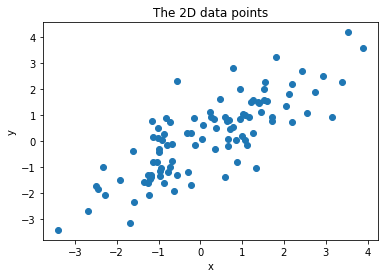

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_data(data, eigen_vectors = None):
    """
    This function plots the data of the given `eigen_vectors` with a scatterplot of the matrix data. 
    If no eigenvectors are available, it just plots the data
    :param data: the data
    :param eigen_vectors: the eigenvectors
    """
    # Plot the features as a scatterplot
    plt.scatter(data[:, 0], data[:, 1])
    
    if eigen_vectors is not None:
        # Plot the two PCA lines
        for vector in eigen_vectors:
            line = _set_line(vector)
            plt.plot(line[0], line[1], 'red')

    plt.show()
    
def _set_line(vector):
    # Fixed number for the line size of this plot
    line_size = 6

    # Set the coordinates for the PCA lines
    axis = np.zeros((2, 2))
    axis[0][0] = vector[0] * line_size
    axis[1][0] = vector[1] * line_size
    axis[0][1] = vector[0] * -line_size
    axis[1][1] = vector[1] * -line_size
    return axis

data = read_data("data/gaussian.txt")
plt.title('The 2D data points')
plt.xlabel('x')
plt.ylabel('y')
plot_data(data)

$\q{2.1}$
Can you predict the direction of the first principal component by looking at the plotted data? What about the second principal component?

$\ex{2.1}$
The principal components of a dataset can also be seen as the eigenvectors of the covariance
matrix. Compute the covariance matrix of the Gaussian dataset as follows:  
  
<center>$cov(X) = \dfrac{1}{N}(X - \bar{x})^\intercal(X - \bar{x})$  </center>

where $\bar{x}$ is a vector containing the mean of each feature. Next, compute the eigenvectors of this covariance matrix and plot the vectors accordingly.

In [28]:
def covariance(data):
    """
    This function computes the computes the covariance matrix of a given `data`.
    :param data: the starting data
    :return: the covariance matrix 
    """
    # START ANSWER
    x_bar = data.mean(axis=0, keepdims=True)
    leftover = data - x_bar
    return 1 / len(data) * leftover.T @ leftover

In [29]:
# Now let's check your implementation with the numpy built-in cov function. 
data = read_data("data/gaussian.txt")
your_cov_matrix = covariance(data)
np_cov_matrix = np.cov(np.transpose(data))

# Your value might differ slightly as the numpy built-in cov function is a bit more precise than our function :).
err_msg = "Your covariance matrix is allowed to differ from the numpy matrix, but no more than ~+-0.025"
np.testing.assert_allclose(np_cov_matrix, your_cov_matrix, atol=0.025, err_msg=err_msg)

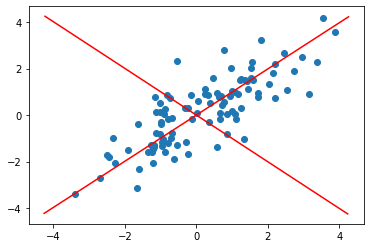

In [30]:
# Use power iteration method to compute the eigenvectors using your covariance matrix and plot the resulting vectors.
# The plot should contain both the dataset (like in the above plot) and the eigenvectors.

# START ANSWER
eigen_vectors = power_iteration(your_cov_matrix)
plot_data(data, eigen_vectors)
# END ANSWER

$\q{2.2}$ Which of these eigenvectors captures the most variance? Was this the first principal component or the second?

For the next exercise, you will need to use the `create_image` function presented below.  
__Note:__ If you have trouble installing PIL, try ```pip install Pillow```.

In [31]:
import math
from PIL import Image

def create_image(fv):
    """
    This function creates a grey image based on the given feature vector `fv`.
    :param fv: the feature vector
    :param title: the title of the image
    """
    width = height = int(math.sqrt(len(fv)))

    # Filter label and threshold from data
    img = Image.new('L', (width, height), "black")
    pixels = img.load()
    min_v = min(fv)
    max_v = max(fv)

    # Iterate over each pixel and set p value
    j = 0
    for (idx, p) in enumerate(fv):
        i = idx % width
        pixel = int(((p - min_v) / (max_v - min_v) * 255))
        pixels[i, j] = pixel
        if i == (width - 1):
            j += 1

    # Resize image to make it better visible
    img = img.resize((256, 256), Image.ANTIALIAS)
    return img

$\ex{2.2}$ Create a matrix object and let it read in `data/faces.txt`. This matrix is of size $N × D$, where $N$ is the number of images in the dataset and $D$ is the number of pixels per image (in this case $32 × 32$, so $D = 1024$). Similar as before, compute the covariance matrix. Use this covariance matrix to compute the first 10 principal components and visualize them using the given `create_image()` function.    
__Note:__ `create_image()` only accepts rows of the dataset (`lists`), use the `transpose` function of `numpy` to convert columns to rows.

Mean image


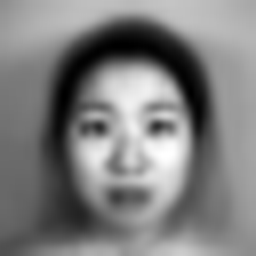

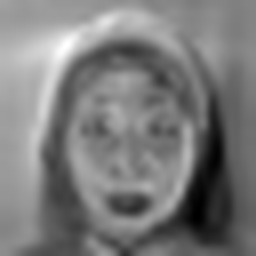

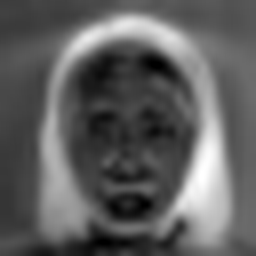

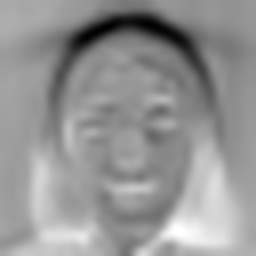

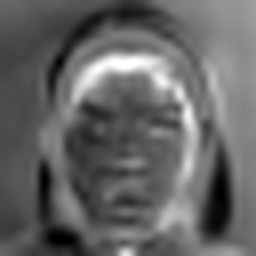

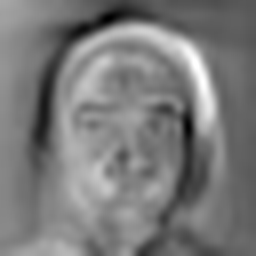

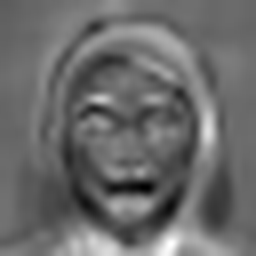

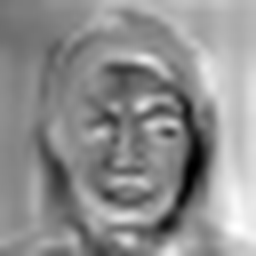

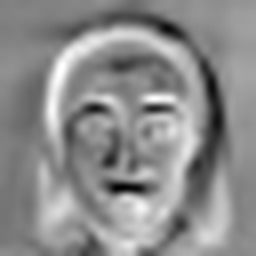

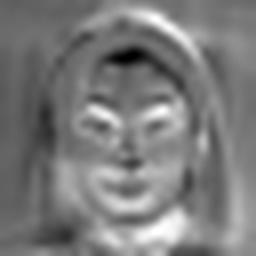

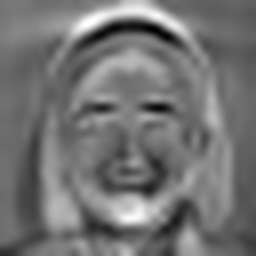

In [38]:
from IPython.display import display # To display images, usage: display(image)

data = read_data("data/faces.txt")

# Display image of the mean
mean = np.mean(data, axis=0)
print("Mean image")
mean_image = create_image(mean)
display(mean_image)

# Now plot the image of each of the eigenvectors of the given dataset
# START ANSWER
cov_matrix = covariance(data)
eigen_vectors = power_iteration(cov_matrix, n_vectors=10)
for eigen_vector in eigen_vectors:
    eigen_image = create_image(eigen_vector)
    display(eigen_image)
# END ANSWER

$\q{2.3}$ What do these principal components mean in terms of faces?
